In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [2]:
A = [[1, 2, 3], [1, 3, 2], [2, 1, 3], [2, 3, 1], [3, 1, 2], [3, 2, 1]]
categories = ["chores", "finances", "activities"]

In [3]:
def insist(x, priorities):
    return [0, 0, 0]


def compromise(x, priorities):
    return [1, 1, 1]


def random(x, priorities):
    return gen.integers(2, size=3)


def titfortat(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x, priorities):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, priorities, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis=0)


def prioritised(x, priorities):
    mid = np.argwhere(priorities[0] == 2)[0, 0]
    return np.array([1, titfortat(x, priorities)[mid], 0])[priorities[0]-1]


def considerate(x, priorities):
    ret = [0,0,0]
    for i in range(3):
        if priorities[0][i] > priorities[1][i]:
            ret[i] = 0
        elif priorities[0][i] == priorities[1][i]:
            ret[i] = titfortat(x, priorities)[i]
        else:
            ret[i] = 1
    return ret

strategies = [insist, compromise, titfortat,
              grim, gradual_forgiving, random, prioritised, considerate]

In [4]:
def game(strategy_A, strategy_B, N, priorities):
    priorities = np.array([priorities, [1,2,3]])
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices, priorities)
        b = strategy_B(choices[::-1], priorities[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

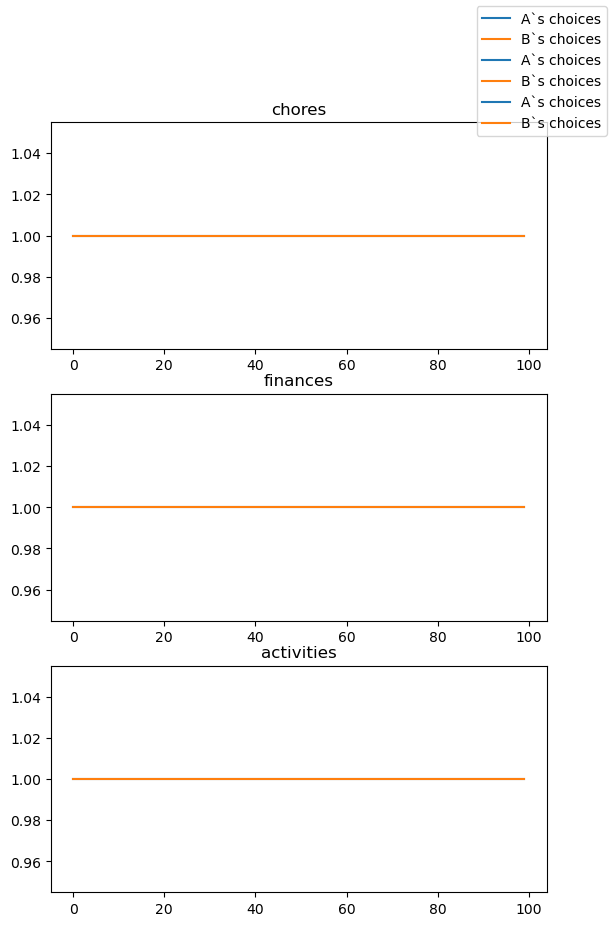

In [5]:
choices = game(considerate, considerate, N=100, priorities = A[0])
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [6]:
def mean_payoffs(strategy_A, strategy_B, N, priorities):
    A = priorities
    B = [1,2,3]
    subgame_payoffs = np.array([[
        [[0, 0],        [A[i], -B[i]]],
        [[-A[i], B[i]], [1.5, 1.5]]]
        for i in range(3)])

    choices = game(strategy_A, strategy_B, N, priorities)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]

    return ret/N

In [7]:
N = 10000

prio_payoffs = []
for prio in A:
    payoffs = []
    for i in range(len(strategies)):
        payoffs.append([])
        for j in range(len(strategies)):
            payoff = mean_payoffs(strategies[i], strategies[j], N = N, priorities = prio)
            payoffs[-1].append(payoff)
    prio_payoffs.append(payoffs)

In [8]:
dfs = []
best_strats = []
labels = [x.__name__ for x in strategies]
for payoffs in prio_payoffs:

    df = pd.DataFrame(payoffs, index=labels, columns=labels)
    tot = np.stack(df.sum(1).values)[:, 0]

    df["Total for Player A"] = tot
    best = [df["Total for Player A"].idxmax(), np.max(tot)]
    best_strats.append(best)

    dfs.append(df.round(3))

    # print(df.to_latex())
best_strats = np.transpose(best_strats)
for df in dfs:
    display(df)

,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[3.0373, -3.0373]","[1.0002, -1.0002]","[0.0006, -0.0006]",10.040
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.80025, 5.25135]","[0.0, 6.0]","[4.5, 4.5]",15.700
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.10605, 1.10705]","[2.9997, 3.0003]","[4.5, 4.5]",26.605
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[3.0139, -3.0133]","[2.9997, 3.0003]","[4.5, 4.5]",28.513
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.85965, -2.72015]","[2.9997, 3.0003]","[4.5, 4.5]",28.359
random,"[-2.9869, 2.9869]","[5.25645, -0.78915]","[1.14195, 1.14135]","[-3.00255, 3.00405]","[-2.72345, 2.85455]","[1.14605, 1.11565]","[0.13515, 2.13915]","[1.1292, 1.128]",0.096
prioritised,"[-1.0002, 1.0002]","[6.0, 0.0]","[3.0003, 2.9997]","[3.0003, 2.9997]","[3.0003, 2.9997]","[2.0952, 0.1398]","[3.0, 3.0]","[3.0003, 2.9997]",22.096
considerate,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.0964, 1.0966]","[2.9997, 3.0003]","[4.5, 4.5]",26.596


,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[3.031, -3.0303]","[1.0003, -1.0002]","[3.0001, -2.0001]",13.033
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.74815, 5.23745]","[1.0, 6.0]","[1.0, 6.0]",13.252
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.124, 1.1242]","[2.9998, 3.0003]","[2.9998, 3.0003]",25.123
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[3.00435, -3.01375]","[2.9998, 3.0003]","[2.9998, 3.0003]",27.003
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.88735, -2.75615]","[2.9998, 3.0003]","[2.9998, 3.0003]",26.886
random,"[-3.0291, 3.0249]","[5.2541, -0.743]","[1.14385, 1.14365]","[-2.9941, 2.9903]","[-2.73605, 2.87205]","[1.1199, 1.1291]","[0.64125, 2.09105]","[1.6448, 1.5983]",1.045
prioritised,"[-1.0002, 1.0003]","[6.0, 1.0]","[3.0003, 2.9998]","[3.0003, 2.9998]","[3.0003, 2.9998]","[2.1497, 0.6439]","[1.5001, 1.5001]","[4.4998, -0.4997]",22.150
considerate,"[-2.0001, 3.0001]","[6.0, 1.0]","[3.0003, 2.9998]","[3.0003, 2.9998]","[3.0003, 2.9998]","[1.62025, 1.61545]","[-0.4997, 4.4998]","[2.5, 2.5]",16.621


,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[2.9802, -2.9742]","[2.0001, -1.0002]","[2.0003, -1.0003]",12.982
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.76075, 5.25695]","[0.0, 6.0]","[2.0, 5.0]",13.239
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.12445, 1.12535]","[2.9997, 3.0003]","[2.9999, 3.0002]",25.123
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.98365, -2.98605]","[2.9997, 3.0003]","[2.9999, 3.0002]",26.983
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.8927, -2.768]","[2.9997, 3.0003]","[2.9999, 3.0002]",26.892
random,"[-3.0092, 3.0097]","[5.24985, -0.74865]","[1.12855, 1.12825]","[-2.99865, 3.00525]","[-2.7562, 2.897]","[1.1539, 1.1047]","[0.64535, 2.11265]","[1.6385, 1.6538]",1.052
prioritised,"[-1.0002, 2.0001]","[6.0, 0.0]","[3.0003, 2.9997]","[3.0003, 2.9997]","[3.0003, 2.9997]","[2.1174, 0.6174]","[3.0, 3.0]","[0.5003, 3.4997]",19.618
considerate,"[-1.0003, 2.0003]","[5.0, 2.0]","[3.0002, 2.9999]","[3.0002, 2.9999]","[3.0002, 2.9999]","[1.64905, 1.63885]","[3.4997, 0.5003]","[2.5, 2.5]",20.649


,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[3.0063, -3.0125]","[2.0003, -1.0002]","[5.0, -3.0]",16.008
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.8118, 5.2658]","[2.0, 6.0]","[2.0, 6.0]",15.188
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.1313, 1.1325]","[2.9999, 3.0003]","[2.9999, 3.0003]",25.130
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.9756, -2.9784]","[2.9999, 3.0003]","[2.9999, 3.0003]",26.975
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.89185, -2.76535]","[2.9999, 3.0003]","[2.9999, 3.0003]",26.891
random,"[-2.9936, 2.9852]","[5.2593, -0.798]","[1.1283, 1.1271]","[-2.9971, 3.0058]","[-2.76875, 2.88895]","[1.119, 1.1645]","[1.637, 2.1221]","[3.5043, 1.4857]",3.888
prioritised,"[-1.0002, 3.0001]","[6.0, 1.0]","[3.0003, 2.9998]","[3.0003, 2.9998]","[3.0003, 2.9998]","[2.13145, 1.63735]","[0.5003, 4.4998]","[3.5, 2.5]",20.132
considerate,"[-1.0, 3.0]","[6.5, -1.5]","[1.5005, 1.4997]","[1.5005, 1.4997]","[1.5005, 1.4997]","[2.75535, 0.74885]","[1.0003, 1.9998]","[4.0, 0.0]",17.757


,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[3.0159, -3.0026]","[3.0001, -1.0002]","[3.0, -1.0]",15.018
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.76585, 5.24575]","[1.0, 6.0]","[-1.5, 6.5]",10.734
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.0919, 1.0926]","[2.9998, 3.0003]","[1.4997, 1.5005]",23.591
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[3.03455, -3.01455]","[2.9998, 3.0003]","[1.4997, 1.5005]",25.533
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.9106, -2.7415]","[2.9998, 3.0003]","[1.4997, 1.5005]",25.410
random,"[-2.9846, 2.9699]","[5.2396, -0.7622]","[1.09335, 1.09255]","[-3.013, 3.0007]","[-2.7425, 2.8579]","[1.13125, 1.10815]","[1.61465, 2.12425]","[0.73265, 2.77975]",1.071
prioritised,"[-1.0002, 2.0003]","[6.0, 2.0]","[3.0003, 2.9999]","[3.0003, 2.9999]","[3.0003, 2.9999]","[2.12565, 1.62295]","[4.4998, 0.5003]","[1.9998, 1.0003]",22.626
considerate,"[-3.0, 5.0]","[6.0, 2.0]","[3.0003, 2.9999]","[3.0003, 2.9999]","[3.0003, 2.9999]","[1.48105, 3.50535]","[2.5, 3.5]","[0.0, 4.0]",15.982


,insist,compromise,titfortat,grim,gradual_forgiving,random,prioritised,considerate,Total for Player A
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0006, -0.0006]","[0.0006, -0.0006]","[0.0006, -0.0006]","[2.9694, -2.9658]","[3.0002, -1.0002]","[3.0002, -1.0002]",14.972
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.75665, 5.24775]","[2.0, 6.0]","[2.0, 6.0]",15.243
titfortat,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.1219, 1.1227]","[2.9999, 3.0003]","[2.9999, 3.0003]",25.121
grim,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.998, -2.974]","[2.9999, 3.0003]","[2.9999, 3.0003]",26.997
gradual_forgiving,"[-0.0006, 0.0006]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.8852, -2.74]","[2.9999, 3.0003]","[2.9999, 3.0003]",26.884
random,"[-3.0001, 2.9875]","[5.24125, -0.73195]","[1.146, 1.1452]","[-2.99525, 3.00355]","[-2.7191, 2.8865]","[1.0837, 1.1345]","[2.10955, 2.12395]","[2.1059, 2.1147]",2.972
prioritised,"[-1.0002, 3.0002]","[6.0, 2.0]","[3.0003, 2.9999]","[3.0003, 2.9999]","[3.0003, 2.9999]","[2.10025, 2.14105]","[3.5, 3.5]","[3.5, 3.5]",23.101
considerate,"[-1.0002, 3.0002]","[6.0, 2.0]","[3.0003, 2.9999]","[3.0003, 2.9999]","[3.0003, 2.9999]","[2.12435, 2.12675]","[3.5, 3.5]","[3.5, 3.5]",23.125


In [9]:

cols = [''.join(map(str,a)) for a in A]
df_best = pd.DataFrame(best_strats, index = ["Best Strategy", "Total Mean Payoff"], columns = cols)
df_best

,123,132,213,231,312,321
Best Strategy,grim,grim,grim,grim,grim,grim
Total Mean Payoff,28.513,27.00335,26.982650000000003,26.974800000000002,25.533450000000002,26.997200000000003


In [10]:
def stochastic(x, p, priorities):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = [p[i][2 * np.array(x[0][-1]) + np.array(x[1][-1])][i] for i in range(3)]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

# p = [[0,1,0,1],
#      [1,0,1,0],
#      [0,0,0,1]]

# x = [[[1,1,1],[1,0,1]],[[1,1,1],[0,1,1]]]

# stochastic(x, p, priorities = [A,B])

In [11]:
def p_evolution(M, N, Q, replaced, rate, priorities):
    scores = np.zeros([Q, M])
    p = gen.uniform(size=[M, 3, 4])
    replaced = int(M * replaced)

    for q in range(Q):
        for m in range(M):
            def s1(x, y): return stochastic(x, p[m], y)
            for s2 in strategies:
                payoffA = mean_payoffs(s1, s2, N=N, priorities = priorities)
                # payoffB = mean_payoffs(s2, s1, N=N)
                scores[q, m] += payoffA[0]
                # scores[q, m] += payoffB[1]

            for j in range(1, replaced+1):
                if q == 0:
                    break

                def s2(x, y): return stochastic(x, p[inds[-j]], y)

                payoffA = mean_payoffs(s1, s2, N=N, priorities=priorities)
                # payoffB = mean_payoffs(s2, s1, N=N, priorities=priorities)
                scores[q, m] += payoffA[0]
                # scores[q, m] += payoffB[1]

        inds = np.argsort(scores[q])
        p[inds[:replaced]] = np.clip(
            p[inds[-replaced:]] + gen.normal(scale=rate, size=[replaced, 3, 4]), 0, 1)
    scores /= (replaced + len(strategies))

    inds = np.argsort(scores[-1])
    scores = scores[:, inds]
    p = p[inds]
    return p, scores

In [26]:
M = 50  # number of strategies
N = 50  # number of rounds each game
Q = 50  # number of iterations
replaced = 0.5  # proportion of strategies replaced each generation
evolution_rate = 0.05  # rate of mutation

p, scores = p_evolution(M, N, Q, replaced, evolution_rate, priorities = A[0])

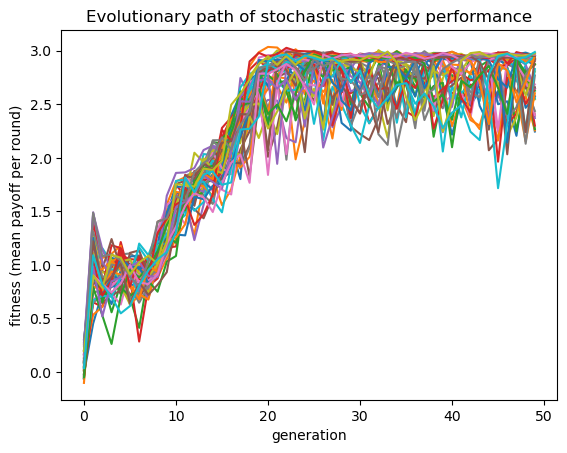

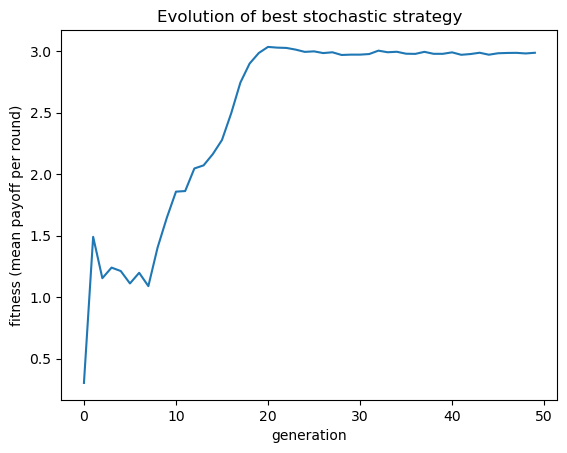

In [29]:
bestscores = scores[:,-int(M * replaced):]
plt.plot(scores)
plt.title("Evolutionary path of stochastic strategy performance")
plt.xlabel("generation")
plt.ylabel("fitness (mean payoff per round)")
plt.savefig("1000 runs.png")
plt.show()
plt.plot(np.max(scores,axis=1))
plt.title("Evolution of best stochastic strategy")
plt.xlabel("generation")
plt.ylabel("fitness (mean payoff per round)")
plt.savefig("1000 runs best.png")


In [30]:
print(f"final best strategy: \n{p[-1]}")

final best strategy: 
[[0.90401957 0.49985814 0.74857324 1.        ]
 [0.23846098 0.26517535 0.34120345 1.        ]
 [0.         0.07487679 0.27712651 0.58431641]]
